* use past upID!=-1 instead of "is sat now

In [1]:
import os
import sys
import time

import numpy as np

from scipy import stats

from astropy import units as u
from astropy import constants as cnst
from astropy.coordinates import SkyCoord, Distance
from astropy import modeling
from astropy import table
from astropy.table import Table
from astropy.io import fits

%matplotlib inline
from matplotlib import rcParams, style
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

rcParams['image.cmap'] = 'viridis'
rcParams['image.origin'] = 'lower'
rcParams['axes.prop_cycle'] = style.library['seaborn-deep']['axes.prop_cycle']
rcParams['figure.figsize'] = (14, 8)
rcParams['axes.titlesize'] =  rcParams['axes.labelsize'] = 16
rcParams['xtick.labelsize'] =  rcParams['ytick.labelsize'] = 14

In [2]:
from importlib import reload
first = lambda x: next(iter(x))

In [3]:
import data_loaders
import detectability

# Load ELVIS and GALFA

In [4]:
elvii_pairs = data_loaders.load_elvii_z0(isolated=False)

Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Hall&Oates.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Hamilton&Burr.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Kek&Kauket.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Lincoln&Douglas.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Orion&Taurus.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Romulus&Remus.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Scylla&Charybdis.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Serena&Venus.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Siegfried&Roy.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Sonny&Cher.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Thelma&Louise.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Zeus&Hera.txt


In [5]:
res = data_loaders.load_galfa_sensitivity('onempc_mass_sens.fits.zip')
galfa_sens, galfa_sens_scs, galfa_sens_wcs, galfa_sens_hdu = res

/Users/erik/miniconda3/lib/python3.5/site-packages/astropy/coordinates/angles.py:656: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/erik/miniconda3/lib/python3.5/site-packages/astropy/coordinates/angles.py:656: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/erik/miniconda3/lib/python3.5/site-packages/astropy/coordinates/angles.py:547: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/erik/miniconda3/lib/python3.5/site-packages/astropy/coordinates/angles.py:547: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):


In [6]:
elvii_trees = data_loaders.load_elvii_trees('ID,Mvir,Vmax,Rvir,upID,scale')

Loading /Users/erik/projects/m31-galfa/elvis_data/PairedTrees/Hall&Oates


/Users/erik/projects/m31-galfa/data_loaders.py:83: RuntimeWarning: divide by zero encountered in true_divide
  coldct['z'] = 1./coldct['scale'] - 1


Loading /Users/erik/projects/m31-galfa/elvis_data/PairedTrees/Hamilton&Burr
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedTrees/Kek&Kauket
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedTrees/Lincoln&Douglas
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedTrees/Orion&Taurus
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedTrees/Romulus&Remus
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedTrees/Scylla&Charybdis
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedTrees/Serena&Venus
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedTrees/Siegfried&Roy
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedTrees/Sonny&Cher
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedTrees/Thelma&Louise
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedTrees/Zeus&Hera


In [7]:
data_loaders.annotate_z0_from_trees(elvii_pairs, elvii_trees)

# Compute detectability and findability for GALFA

In [8]:
#m31 = SkyCoord.from_name('M31')
m31 = SkyCoord(10.6847083*u.deg, 41.26875*u.deg, 700*u.kpc)

for tab in elvii_pairs.values():
    data_loaders.add_oriented_radecs(tab, 0, 1, target_coord=m31)
    data_loaders.add_oriented_radecs(tab, 1, 0, target_coord=m31)

/Users/erik/miniconda3/lib/python3.5/site-packages/astropy/units/quantity.py:782: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return super(Quantity, self).__eq__(other)


In [9]:
detectability.compute_elvis_mgas_bradford_15(elvii_pairs, 'Mstar_preferred')

In [10]:
detectability.compute_elvis_detectability(galfa_sens, galfa_sens_wcs, 'dr1', elvii_pairs)

In [11]:
wakker_hvcs = Table.read('wakk.fits')
wakker_scs = SkyCoord(l=wakker_hvcs['L'], b=wakker_hvcs['B'], unit=u.deg, frame='galactic')

detectability.compute_elvis_findable(elvii_pairs, wakker_scs, wakker_hvcs['VLSR']*u.km/u.s)

# And figure out how to map halos to high-z Tvir

In [12]:
for name, tree in elvii_trees.items():
    for z_re in (6,7,8,9):
        idxzre = np.argmin(np.abs(tree[0]['z']-z_re))    
        elvii_pairs[name]['Mviratz{}'.format(z_re)] = tree['Mvir'][:, idxzre]
        elvii_pairs[name]['Rviratz{}'.format(z_re)] = tree['Rvir'][:, idxzre]
        elvii_pairs[name]['Vmatz{}'.format(z_re)] = tree['Vmax'][:, idxzre]

In [13]:
# values from the "Probabilistic Experiments" notebook
lmvirtolrvir =  modeling.models.Linear1D(slope=0.3332146169115156, intercept=-1.4803268453825718)

vtoltvir = lambda v: np.log10((0.6 * cnst.m_p*v**2 / 2 / cnst.k_B)/u.K)
def lmtoltvir(lmvir):
    lrvir = lmvirtolrvir(lmvir)
    vsq = cnst.G * 10**lmvir/10**lrvir * (u.solMass/u.kpc)
    return np.log10((0.6 * cnst.m_p*vsq / 2 / cnst.k_B)/u.K)

# Probabilistic model 

In [14]:
lmvg, rmg, zg = np.meshgrid(np.linspace(5.5,9.5, 25), 
                            np.linspace(8,22, 25), 
                            [6, 7, 8, 9])

In [15]:
PARAMETERS = ['logmvcut', 'zre', 'rmagcut']
MINF = -np.inf

def counts_with_cutoffs(Mviratzre=0*u.solMass, z_re=8, appmagcut=100*u.mag, inclsat=False):
    counts = []
    for pair in elvii_pairs.values():
        halos = pair[2:]
        for i in (0, 1):
            matches = halos['findable_dr1_host{}'.format(i)]
            
            if Mviratzre is not None:
                matches = matches & (halos['Mviratz{}'.format(z_re)] > Mviratzre)
            
            dm = Distance(halos['host{}_dist'.format(i)]).distmod
            appmag = -2.5*np.log10(halos['Mstar_preferred']/u.solMass)*u.mag + dm 
            matches = matches & (appmag < appmagcut)
            
            if not inclsat:
                matches = matches & ~halos['upIDever_either']
                
            counts.append(np.sum(matches))
    return np.array(counts)

def lnprior(logmvcut, zre, rmagcut):
    if not (5.5 < zre < 9.5):
        return MINF
    if not (8 < rmagcut < 22):
        return MINF
    if not (5 < logmvcut < 10.5):
        return MINF
    return 0

def lnlike(logmvcut, zre, rmagcut, dosmoothing, ncounts=0):
    appmagcut = (rmagcut - 4.7)*u.mag # appropriate for ~r with M/L=1
    
    counts = counts_with_cutoffs(Mviratzre=10**logmvcut * u.solMass, z_re=int(round(zre)), 
                                 appmagcut=appmagcut, inclsat=False)
    if np.sum(counts)==0:
        return float(ncounts==0)
    elif dosmoothing:
        kde = stats.gaussian_kde(counts, 'scott')
        ns = np.arange(round(np.max(counts)*1.5))
        ps = kde(ns)
        p = ps[ncounts]/np.sum(ps)
    else:
        p = np.sum(counts==ncounts)/len(counts)
        
    return np.log(p)
    
def lnprob(pars, dosmoothing):
    logmvcut, zre, rmagcut = pars
    
    lpri = lnprior(logmvcut, zre, rmagcut)
    if lpri == MINF:
        return MINF
    
    return lpri + lnlike(logmvcut, zre, rmagcut, dosmoothing)

In [16]:
vlnlike = np.vectorize(lnlike, excluded='dosmoothing,ncounts'.split(','))
st = time.time()
lnl = vlnlike(lmvg, zg, rmg, False)
et = time.time()
print((et-st)/lnl.size, 's per sample and', et-st, 's total')

/Users/erik/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: divide by zero encountered in log


0.2313936964035034 s per sample and 578.4842410087585 s total


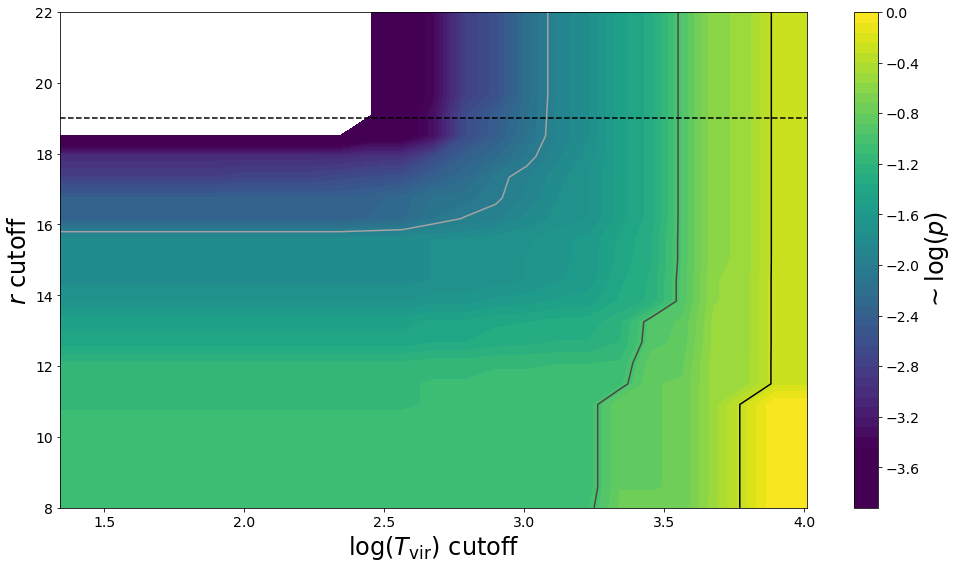

In [17]:
pish = np.mean(lnl, axis=2)
pish -= np.max(pish)

vmin = None
vmin = -3.44 # this makes the colormap match the other plots

plt.contourf(lmtoltvir(lmvg[:,:,0]), rmg[:,:,0], pish, 50,vmin=vmin)
plt.colorbar().set_label(r'$\sim \log(p)$', fontsize=24)
plt.contour(lmtoltvir(lmvg[:,:,0]), rmg[:,:,0], pish, [-2, -1, np.log10(0.5)], cmap='Greys',vmin=vmin)
plt.axhline(17.5+1.5, c='k', ls='--')
plt.xlabel(r'$\log(T_{\rm vir})$ cutoff', fontsize=24)
plt.ylabel(r'$r$ cutoff', fontsize=24)
plt.tight_layout()

fig = plt.gcf()

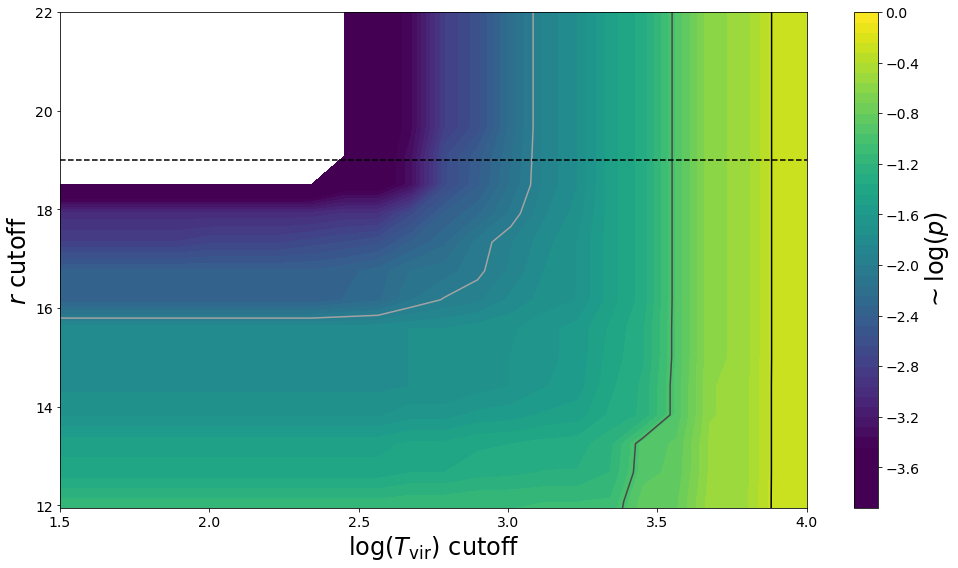

In [18]:
fig.axes[0].set_xlim(1.5,4)
fig.axes[0].set_ylim(11.95,22)
#fig.savefig('paper/reionizationp.pdf')
fig

# Write out table for Josh 

In [19]:
tabs = []
mpair = []
for name, pairs in elvii_pairs.items():
    for i in (0, 1):
        otheri = int(not bool(i))
        tab = Table()
        tab['in_dr1'] = pairs['in_survey_dr1_host' + str(i)].astype(int)
        tab['detectable_dr1'] = pairs['detectable_dr1_host' + str(i)].astype(int)
        tab['vel_cuts'] = pairs['host{}_vdevok'.format(i)]&pairs['host{}_dHVCok'.format(i)].astype(int)
        tab['sat_now'] = pairs['sat_of_either'].astype(int)
        tab['sat_ever'] = pairs['upIDever_either'].astype(int)
        tabs.append(tab)
        mpair.append(np.sum(pairs['Mvir'][:2])+ (1*u.solMass if pairs['Mvir'][i]>pairs['Mvir'][otheri] else 0))
mpair = u.Quantity(mpair)
tabs = np.array(tabs, dtype=object)
sorti = np.argsort(mpair)
tabss = tabs[sorti]

In [20]:
hl = fits.HDUList()
for tab in tabss:
    hl.append(fits.BinTableHDU(data=np.array(tab)))
    
#hl.writeto('data_for_venn_diagram_sorted_smalltolarge.fits.gz', clobber=True)

# Test version of final figure

In [27]:
from astropy import modeling

xs6 = []
ys6 = []
xs9 = []
ys9 = []
for nm, pair in elvii_pairs.items():
    xs6.append(np.log10(pair['Mviratz6'].value))
    ys6.append(np.log10(pair['Rviratz6'].value))
    xs9.append(np.log10(pair['Mviratz9'].value))
    ys9.append(np.log10(pair['Rviratz9'].value))

mv6 = np.concatenate(xs6)
rv6 = np.concatenate(ys6)
mv9 = np.concatenate(xs9)
rv9 = np.concatenate(ys9)

mvs = np.concatenate((mv6, mv9))
rvs = np.concatenate((rv6, rv9))


msk = np.isfinite(mvs)&np.isfinite(rvs)
lmvirtolrvir = modeling.fitting.LinearLSQFitter()(modeling.models.Linear1D(), mvs[msk], rvs[msk])

/Users/erik/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10
/Users/erik/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log10
/Users/erik/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log10
/Users/erik/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log10


In [28]:
lmvir0 = []
lmpeak = []
lmstars = []
lmgass = []
for nm, pair in elvii_pairs.items():
    lmvir0.append(np.log10(pair['Mvir']/u.solMass))
    lmpeak.append(np.log10(pair['Mpeak']/u.solMass))
    lmstars.append(np.log10(pair['Mstar_preferred']/u.solMass))
    lmgass.append(np.log10(pair['MHI']/u.solMass))

lmvir0 = np.concatenate(lmvir0)
lmpeak = np.concatenate(lmpeak)
lmstars = np.concatenate(lmstars)
lmgass = np.concatenate(lmgass)

/Users/erik/miniconda3/lib/python3.5/site-packages/astropy/units/quantity.py:841: RuntimeWarning: invalid value encountered in true_divide
  return super(Quantity, self).__truediv__(other)


324

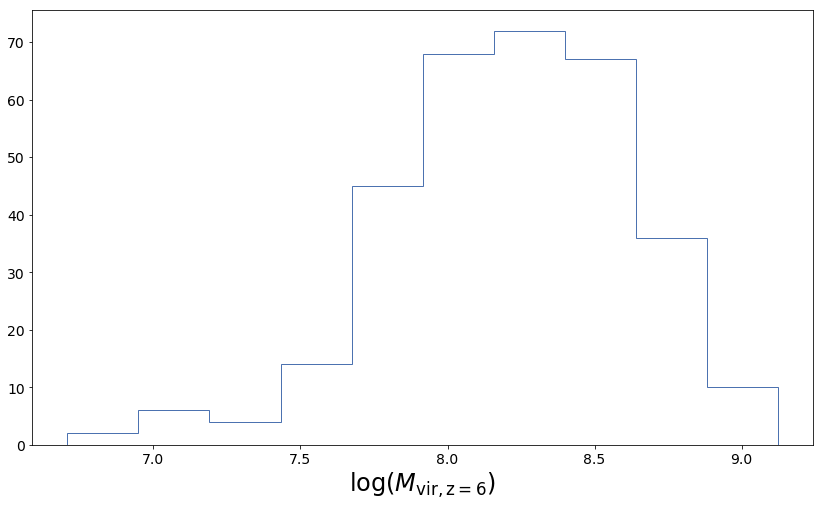

In [29]:
leot_mstar = 1.4e5*u.solMass
leot_mhi = 2.8e5*u.solMass
leot_lmstar = np.log10(leot_mstar/u.solMass)
ltv6 = lmtoltvir(mv6)
ltv9 = lmtoltvir(mv9)
meanlt = ltv6

dlmstar = .1
nearleot = ((leot_lmstar-dlmstar) < lmstars)&(lmstars < (leot_lmstar+dlmstar))

ltnear = meanlt[nearleot]
lmnear6 = mv6[nearleot]

plt.hist(lmnear6[np.isfinite(lmnear6)], histtype='step')
plt.xlabel(r'$\log(M_{\rm vir,z=6})$', fontsize=24)

np.sum(nearleot)

In [31]:
pish = np.mean(lnl, axis=2)
#pish = lnl[:,:, 0]
pish -= np.max(pish)

magtoslice = 19
diff = np.abs(rmg[:,:,0] - magtoslice)
closest = np.min(diff) == diff

assert len(np.unique(rmg[closest])) == 1
rmclosest = rmg[closest][0]

lmclose = lmvg[:,:,0][closest]
ltvclose = lmtoltvir(lmclose)
pclose = pish[closest]

In [34]:
leot_cdfx = np.sort(lmnear6[np.isfinite(lmnear6)])
leot_cdfy = np.linspace(1, 0, len(lmnear6))

#plt.plot(leot_cdfx, leot_cdfy)
#plt.plot(lmclose, 10**pclose)

combined_x = np.sort(np.concatenate((leot_cdfx, lmclose)))

leot_cdf_combined = np.interp(combined_x, leot_cdfx, leot_cdfy)
cutoff_cdf_combined = np.interp(combined_x, lmclose, 10**pclose)
both_cdfs_combined = leot_cdf_combined*cutoff_cdf_combined
both_cdfs_combined /= np.max(both_cdfs_combined)


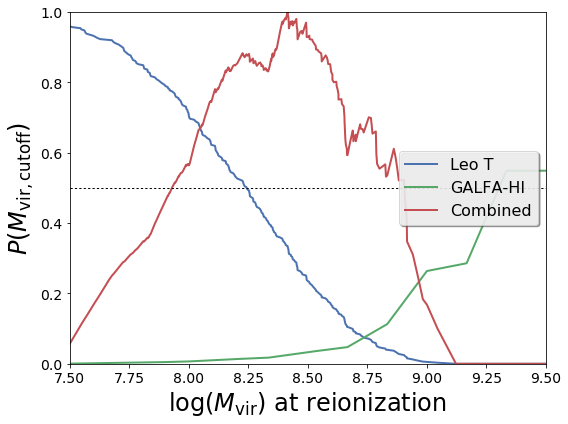

In [46]:
plt.figure(figsize=(8,6))

combined_x = np.sort(np.concatenate((leot_cdfx, lmclose)))

leot_cdf_combined = np.interp(combined_x, leot_cdfx, leot_cdfy)
cutoff_cdf_combined = np.interp(combined_x, lmclose, 10**pclose)
both_cdfs_combined = leot_cdf_combined*cutoff_cdf_combined
both_cdfs_combined /= np.max(both_cdfs_combined)

plt.plot(combined_x, leot_cdf_combined, lw=2, label='Leo T')
plt.plot(combined_x, cutoff_cdf_combined, lw=2, label='GALFA-HI')
plt.plot(combined_x, both_cdfs_combined, lw=2, label='Combined')
plt.axhline(.5, ls=':', lw=1, c='k')

plt.xlim(7.5, 9.5)
plt.ylim(0, 1.0)

plt.xlabel(r'$\log(M_{\rm vir})$ at reionization', fontsize=24)
plt.ylabel(r'$P(M_{\rm vir, cutoff})$', fontsize=24)
plt.legend(loc='center right', fontsize=16, shadow=True) 
plt.tight_layout()
plt.savefig('paper/leot_galfa_combo_notever.eps')